Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií Vehicle Routing Problem, což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezeně vozidel jednoho stejného typu. Vstupní data najdete ve složce domaci_ukol_data, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:

Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.
Svůj kód, popis řešení a výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline.

In [141]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint
import matplotlib.cm as cm

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# Řešení
Upravená implementace ze cvika. Představuju si, že každý mravenec je jedno auto a pokud už má naloženo maximální kapacitu, tak jeho cesta končí (resp se vrací do depa). Když není možné přidat to nejpravděpodobnější další místo, protože je moc velké, tak hledám nejblížší pravděpodobné takové, že se tam vejde (přitom si vždycky znova "hodím kostkou", šlo udělat i to, abych udělala jenom jeden náhodný pokus a pak našla nějakou možnou cestu). Zkoušela jsem i jenom ukončit cestu, když to tam nejde přidat, ale to samozřejmě vedlo k horším výsledkům, zejména v počtu aut. 

Zkoušela jsem tři rlzné fitness (jsou vidět zakomentované v kódu). Nevím jak moc je drahé použít další auto oproti delší cestě, ale předpokládám, že víc (potřebuju platit dalšího řidiče vs. bude mi to trochu dýl trvat), takže je na počet aut fitness celkem citlivá. 

## Grafík k řešení
Vykreslila jsem si cesty pro jednotlivá auta (každé jinou barvou). Při menším počtu iterací to vypadá, že skoro každé auto má nějakou svojí "oblast", které se věnuje a nepřejíždí tedy chaoticky sem a tam, ale pro větší počet a teda i lepší řešení je výsledná množina tras dost pomíchaná.

In [138]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y', 'quantity'])

@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

# TODO do fitness pridat jeste pocet aut
def fitness(vertices, distance, solution):
    solution_distance = 0
    num_cars = solution[-1]
    solution = solution[:-1]
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    #fitness_result = solution_distance + num_cars*(solution_distance/(len(solution)-1))
    #fitness_result = solution_distance*num_cars
    fitness_result = solution_distance + solution_distance*num_cars
    return fitness_result

def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

# vytvoreni reseni
def generate_solutions(vertices, pheromones, distance, N,alpha=1, beta=3):
    
    # pravdepodobnost vyberu dalsiho mesta
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    pheromones_shape = pheromones.shape[0]
    available = list(range(pheromones_shape))
    solution = [0]
    available.remove(0)
    num_cars = 0
    cars = []
    for i in range(N):
        weight = 0
        if not available:
            num_cars = i
            solution.append(num_cars)
            break
        while available:
            av = available.copy()
            while av:
                probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), av)))
                selected = np.random.choice(av, p=probs/sum(probs)) # vyber hrany
                weight_new = vertices[selected].quantity
                if weight + weight_new <= vehicle_capacity:
                    solution.append(selected)
                    available.remove(selected)
                    av.remove(selected)
                    weight = weight + weight_new
                else:
                    av.remove(selected)
            cars.append(len(solution))
            break
    yield (solution, cars)

# hlavni kod ACO
def ant_solver(vertices, distance,places,ants=10, max_iterations=3000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    best_num_cars = None
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones, distance, ants,alpha=alpha, beta=beta))
        cars = solutions[0][1]
        solutions = [solutions[0][0]]
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
                best_num_cars = s[-1]
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')

    return best_solution, pheromones, cars

# Načtení dat

In [139]:
def load_data(name):
    path  = "./domaci_ukol_data/data_"
    dataset = name
    import xml.etree.ElementTree as ET
    tree = ET.parse(path + dataset + ".xml")
    root = tree.getroot()
    nodes = root[1][0]
    vehicle_capacity = float(root[2][0][2].text)
    print(vehicle_capacity)
    requests = root[3]
    vertices = []
    n = nodes[0]
    depo = Vertex(n.attrib["id"], float(nodes[0][0].text), float(nodes[0][1].text), 0)
    vertices.append(depo)
    for n in requests:
        vertices.append(Vertex(n.attrib["id"], float(nodes[int(n.attrib["node"])-1][0].text), float(nodes[int(n.attrib["node"])-1][1].text), float(n[0].text))) 

# Pokusy

100.0
   0, 2409.2934, 2409.2934, 2409.2934
   1, 2271.1812, 2271.1812, 2271.1812
   2, 3072.2336, 3072.2336, 3072.2336
   3, 3200.7829, 3200.7829, 3200.7829
   4, 3542.1992, 3542.1992, 3542.1992
   5, 3849.5109, 3849.5109, 3849.5109
   6, 4180.7053, 4180.7053, 4180.7053
   7, 4497.6782, 4497.6782, 4497.6782
   8, 4260.3720, 4260.3720, 4260.3720
   9, 6011.6675, 6011.6675, 6011.6675
  10, 4082.5819, 4082.5819, 4082.5819
  11, 4191.3782, 4191.3782, 4191.3782
  12, 4184.9745, 4184.9745, 4184.9745
  13, 4380.7966, 4380.7966, 4380.7966
  14, 4121.8593, 4121.8593, 4121.8593
  15, 4126.0454, 4126.0454, 4126.0454
  16, 3683.1155, 3683.1155, 3683.1155
  17, 4020.6997, 4020.6997, 4020.6997
  18, 4772.8690, 4772.8690, 4772.8690
  19, 4534.6944, 4534.6944, 4534.6944
  20, 4183.6327, 4183.6327, 4183.6327
  21, 4555.3664, 4555.3664, 4555.3664
  22, 4463.0701, 4463.0701, 4463.0701
  23, 4869.8635, 4869.8635, 4869.8635
  24, 3625.0404, 3625.0404, 3625.0404
  25, 4553.5015, 4553.5015, 4553.5015
  26, 

 220, 4842.7214, 4842.7214, 4842.7214
 221, 4905.2415, 4905.2415, 4905.2415
 222, 5223.1232, 5223.1232, 5223.1232
 223, 4820.2184, 4820.2184, 4820.2184
 224, 4661.7490, 4661.7490, 4661.7490
 225, 4745.3552, 4745.3552, 4745.3552
 226, 4999.8864, 4999.8864, 4999.8864
 227, 4902.8108, 4902.8108, 4902.8108
 228, 5281.2376, 5281.2376, 5281.2376
 229, 4948.4576, 4948.4576, 4948.4576
 230, 5109.4241, 5109.4241, 5109.4241
 231, 5708.2505, 5708.2505, 5708.2505
 232, 5265.0589, 5265.0589, 5265.0589
 233, 5170.5428, 5170.5428, 5170.5428
 234, 4974.6208, 4974.6208, 4974.6208
 235, 4824.1075, 4824.1075, 4824.1075
 236, 4393.5686, 4393.5686, 4393.5686
 237, 4255.0562, 4255.0562, 4255.0562
 238, 4582.6829, 4582.6829, 4582.6829
 239, 4186.8358, 4186.8358, 4186.8358
 240, 4815.6669, 4815.6669, 4815.6669
 241, 5124.2753, 5124.2753, 5124.2753
 242, 4714.4015, 4714.4015, 4714.4015
 243, 5453.0782, 5453.0782, 5453.0782
 244, 4415.2800, 4415.2800, 4415.2800
 245, 5440.4997, 5440.4997, 5440.4997
 246, 4890.8

 437, 4969.4145, 4969.4145, 4969.4145
 438, 5121.1929, 5121.1929, 5121.1929
 439, 4771.6059, 4771.6059, 4771.6059
 440, 5018.2123, 5018.2123, 5018.2123
 441, 5113.2493, 5113.2493, 5113.2493
 442, 4736.7784, 4736.7784, 4736.7784
 443, 4918.5461, 4918.5461, 4918.5461
 444, 4888.1017, 4888.1017, 4888.1017
 445, 5005.7267, 5005.7267, 5005.7267
 446, 4064.4441, 4064.4441, 4064.4441
 447, 5240.9362, 5240.9362, 5240.9362
 448, 4571.1414, 4571.1414, 4571.1414
 449, 4317.6493, 4317.6493, 4317.6493
 450, 4160.4275, 4160.4275, 4160.4275
 451, 4541.1246, 4541.1246, 4541.1246
 452, 4999.2785, 4999.2785, 4999.2785
 453, 4386.9371, 4386.9371, 4386.9371
 454, 4546.2713, 4546.2713, 4546.2713
 455, 4905.5127, 4905.5127, 4905.5127
 456, 4870.4209, 4870.4209, 4870.4209
 457, 5092.9625, 5092.9625, 5092.9625
 458, 5079.4264, 5079.4264, 5079.4264
 459, 5261.5592, 5261.5592, 5261.5592
 460, 5007.4544, 5007.4544, 5007.4544
 461, 5486.9556, 5486.9556, 5486.9556
 462, 5347.1205, 5347.1205, 5347.1205
 463, 5309.7

 656, 5871.2656, 5871.2656, 5871.2656
 657, 5023.1941, 5023.1941, 5023.1941
 658, 5466.8845, 5466.8845, 5466.8845
 659, 4748.1399, 4748.1399, 4748.1399
 660, 4112.2343, 4112.2343, 4112.2343
 661, 4347.7904, 4347.7904, 4347.7904
 662, 4709.7480, 4709.7480, 4709.7480
 663, 5138.3853, 5138.3853, 5138.3853
 664, 4652.7300, 4652.7300, 4652.7300
 665, 4943.0426, 4943.0426, 4943.0426
 666, 5109.4306, 5109.4306, 5109.4306
 667, 4556.5118, 4556.5118, 4556.5118
 668, 4696.9833, 4696.9833, 4696.9833
 669, 4320.5296, 4320.5296, 4320.5296
 670, 4997.0022, 4997.0022, 4997.0022
 671, 4376.7390, 4376.7390, 4376.7390
 672, 4120.9941, 4120.9941, 4120.9941
 673, 4470.5848, 4470.5848, 4470.5848
 674, 4768.6601, 4768.6601, 4768.6601
 675, 4443.0912, 4443.0912, 4443.0912
 676, 4130.0959, 4130.0959, 4130.0959
 677, 4483.4369, 4483.4369, 4483.4369
 678, 4606.1307, 4606.1307, 4606.1307
 679, 3849.4518, 3849.4518, 3849.4518
 680, 4229.2211, 4229.2211, 4229.2211
 681, 4216.1857, 4216.1857, 4216.1857
 682, 4662.4

 882, 6329.1207, 6329.1207, 6329.1207
 883, 5423.5339, 5423.5339, 5423.5339
 884, 4840.1476, 4840.1476, 4840.1476
 885, 4739.5516, 4739.5516, 4739.5516
 886, 4264.9735, 4264.9735, 4264.9735
 887, 5418.1686, 5418.1686, 5418.1686
 888, 5373.5855, 5373.5855, 5373.5855
 889, 5387.8250, 5387.8250, 5387.8250
 890, 4620.1963, 4620.1963, 4620.1963
 891, 4591.1924, 4591.1924, 4591.1924
 892, 4882.0809, 4882.0809, 4882.0809
 893, 4694.1102, 4694.1102, 4694.1102
 894, 5050.0163, 5050.0163, 5050.0163
 895, 4327.5508, 4327.5508, 4327.5508
 896, 4823.4305, 4823.4305, 4823.4305
 897, 4827.4839, 4827.4839, 4827.4839
 898, 4728.9954, 4728.9954, 4728.9954
 899, 4950.6288, 4950.6288, 4950.6288
 900, 4831.9007, 4831.9007, 4831.9007
 901, 5282.0888, 5282.0888, 5282.0888
 902, 4611.0432, 4611.0432, 4611.0432
 903, 4988.4492, 4988.4492, 4988.4492
 904, 5291.3193, 5291.3193, 5291.3193
 905, 5104.0204, 5104.0204, 5104.0204
 906, 4666.7981, 4666.7981, 4666.7981
 907, 6426.3787, 6426.3787, 6426.3787
 908, 5176.0

1102, 4813.6438, 4813.6438, 4813.6438
1103, 4380.5247, 4380.5247, 4380.5247
1104, 5097.4403, 5097.4403, 5097.4403
1105, 4933.0007, 4933.0007, 4933.0007
1106, 5553.9077, 5553.9077, 5553.9077
1107, 5057.4978, 5057.4978, 5057.4978
1108, 5299.3110, 5299.3110, 5299.3110
1109, 4585.6093, 4585.6093, 4585.6093
1110, 5476.0165, 5476.0165, 5476.0165
1111, 6541.9698, 6541.9698, 6541.9698
1112, 4978.9221, 4978.9221, 4978.9221
1113, 4993.6039, 4993.6039, 4993.6039
1114, 5022.7626, 5022.7626, 5022.7626
1115, 5488.7400, 5488.7400, 5488.7400
1116, 4938.9416, 4938.9416, 4938.9416
1117, 5688.7116, 5688.7116, 5688.7116
1118, 5345.5058, 5345.5058, 5345.5058
1119, 4883.7373, 4883.7373, 4883.7373
1120, 4635.7321, 4635.7321, 4635.7321
1121, 5077.5213, 5077.5213, 5077.5213
1122, 4697.1057, 4697.1057, 4697.1057
1123, 4976.7740, 4976.7740, 4976.7740
1124, 4861.8899, 4861.8899, 4861.8899
1125, 4804.8026, 4804.8026, 4804.8026
1126, 5085.9921, 5085.9921, 5085.9921
1127, 4485.4132, 4485.4132, 4485.4132
1128, 4316.4

1320, 5512.7221, 5512.7221, 5512.7221
1321, 5408.6500, 5408.6500, 5408.6500
1322, 4630.5661, 4630.5661, 4630.5661
1323, 5481.2667, 5481.2667, 5481.2667
1324, 6134.4182, 6134.4182, 6134.4182
1325, 5400.5017, 5400.5017, 5400.5017
1326, 5653.6954, 5653.6954, 5653.6954
1327, 5369.5195, 5369.5195, 5369.5195
1328, 4882.4489, 4882.4489, 4882.4489
1329, 5167.0455, 5167.0455, 5167.0455
1330, 4804.0130, 4804.0130, 4804.0130
1331, 5005.2244, 5005.2244, 5005.2244
1332, 5071.6927, 5071.6927, 5071.6927
1333, 4300.4601, 4300.4601, 4300.4601
1334, 4739.1639, 4739.1639, 4739.1639
1335, 5115.9496, 5115.9496, 5115.9496
1336, 5494.0098, 5494.0098, 5494.0098
1337, 4812.5903, 4812.5903, 4812.5903
1338, 4708.6635, 4708.6635, 4708.6635
1339, 4110.0646, 4110.0646, 4110.0646
1340, 4342.1790, 4342.1790, 4342.1790
1341, 5090.6819, 5090.6819, 5090.6819
1342, 4119.6787, 4119.6787, 4119.6787
1343, 4571.7926, 4571.7926, 4571.7926
1344, 5210.0685, 5210.0685, 5210.0685
1345, 4922.2660, 4922.2660, 4922.2660
1346, 4702.2

1538, 5020.6952, 5020.6952, 5020.6952
1539, 5294.7037, 5294.7037, 5294.7037
1540, 4727.2790, 4727.2790, 4727.2790
1541, 5174.3113, 5174.3113, 5174.3113
1542, 4850.9277, 4850.9277, 4850.9277
1543, 4884.3680, 4884.3680, 4884.3680
1544, 4383.0408, 4383.0408, 4383.0408
1545, 5099.1270, 5099.1270, 5099.1270
1546, 5407.2066, 5407.2066, 5407.2066
1547, 4969.7477, 4969.7477, 4969.7477
1548, 5240.2728, 5240.2728, 5240.2728
1549, 5391.0002, 5391.0002, 5391.0002
1550, 5134.1625, 5134.1625, 5134.1625
1551, 4564.0716, 4564.0716, 4564.0716
1552, 5365.3437, 5365.3437, 5365.3437
1553, 4405.7289, 4405.7289, 4405.7289
1554, 5100.2927, 5100.2927, 5100.2927
1555, 5383.8770, 5383.8770, 5383.8770
1556, 5093.6229, 5093.6229, 5093.6229
1557, 4827.4562, 4827.4562, 4827.4562
1558, 4685.7447, 4685.7447, 4685.7447
1559, 4118.0867, 4118.0867, 4118.0867
1560, 4975.4451, 4975.4451, 4975.4451
1561, 4851.4466, 4851.4466, 4851.4466
1562, 5560.4284, 5560.4284, 5560.4284
1563, 4634.5522, 4634.5522, 4634.5522
1564, 5942.4

1765, 4167.9305, 4167.9305, 4167.9305
1766, 4805.2612, 4805.2612, 4805.2612
1767, 5108.6120, 5108.6120, 5108.6120
1768, 5325.9145, 5325.9145, 5325.9145
1769, 4815.4251, 4815.4251, 4815.4251
1770, 5163.1920, 5163.1920, 5163.1920
1771, 4461.9139, 4461.9139, 4461.9139
1772, 4454.3552, 4454.3552, 4454.3552
1773, 4420.1571, 4420.1571, 4420.1571
1774, 4044.8544, 4044.8544, 4044.8544
1775, 4545.9348, 4545.9348, 4545.9348
1776, 4855.4029, 4855.4029, 4855.4029
1777, 4755.0624, 4755.0624, 4755.0624
1778, 5177.6692, 5177.6692, 5177.6692
1779, 5606.9893, 5606.9893, 5606.9893
1780, 5765.9484, 5765.9484, 5765.9484
1781, 5015.0441, 5015.0441, 5015.0441
1782, 4497.3317, 4497.3317, 4497.3317
1783, 4777.2459, 4777.2459, 4777.2459
1784, 4603.4752, 4603.4752, 4603.4752
1785, 4164.8719, 4164.8719, 4164.8719
1786, 4865.6619, 4865.6619, 4865.6619
1787, 4115.5010, 4115.5010, 4115.5010
1788, 4599.5575, 4599.5575, 4599.5575
1789, 4815.9727, 4815.9727, 4815.9727
1790, 4691.1646, 4691.1646, 4691.1646
1791, 4683.2

1985, 4477.2443, 4477.2443, 4477.2443
1986, 4981.9148, 4981.9148, 4981.9148
1987, 5371.0403, 5371.0403, 5371.0403
1988, 4577.9606, 4577.9606, 4577.9606
1989, 4821.7643, 4821.7643, 4821.7643
1990, 4828.8959, 4828.8959, 4828.8959
1991, 4901.2357, 4901.2357, 4901.2357
1992, 4292.3747, 4292.3747, 4292.3747
1993, 5057.9138, 5057.9138, 5057.9138
1994, 5307.9252, 5307.9252, 5307.9252
1995, 4500.9659, 4500.9659, 4500.9659
1996, 5138.0810, 5138.0810, 5138.0810
1997, 5257.3177, 5257.3177, 5257.3177
1998, 5400.6959, 5400.6959, 5400.6959
1999, 4456.9370, 4456.9370, 4456.9370
2000, 4630.0430, 4630.0430, 4630.0430
2001, 5292.7244, 5292.7244, 5292.7244
2002, 5646.9612, 5646.9612, 5646.9612
2003, 4955.3227, 4955.3227, 4955.3227
2004, 4790.7730, 4790.7730, 4790.7730
2005, 6126.3153, 6126.3153, 6126.3153
2006, 5232.9217, 5232.9217, 5232.9217
2007, 5291.8128, 5291.8128, 5291.8128
2008, 5367.0447, 5367.0447, 5367.0447
2009, 5409.4742, 5409.4742, 5409.4742
2010, 5497.7387, 5497.7387, 5497.7387
2011, 5408.9

2201, 5598.7640, 5598.7640, 5598.7640
2202, 5606.4897, 5606.4897, 5606.4897
2203, 5842.4816, 5842.4816, 5842.4816
2204, 5375.7559, 5375.7559, 5375.7559
2205, 5414.6878, 5414.6878, 5414.6878
2206, 5628.3676, 5628.3676, 5628.3676
2207, 4881.7372, 4881.7372, 4881.7372
2208, 4877.4641, 4877.4641, 4877.4641
2209, 4422.1373, 4422.1373, 4422.1373
2210, 4165.3343, 4165.3343, 4165.3343
2211, 4606.5363, 4606.5363, 4606.5363
2212, 4914.4033, 4914.4033, 4914.4033
2213, 4155.6663, 4155.6663, 4155.6663
2214, 5157.9849, 5157.9849, 5157.9849
2215, 5199.0225, 5199.0225, 5199.0225
2216, 5885.4041, 5885.4041, 5885.4041
2217, 5647.7801, 5647.7801, 5647.7801
2218, 5585.3584, 5585.3584, 5585.3584
2219, 5071.0676, 5071.0676, 5071.0676
2220, 4751.2949, 4751.2949, 4751.2949
2221, 5486.2188, 5486.2188, 5486.2188
2222, 6143.0009, 6143.0009, 6143.0009
2223, 5367.0215, 5367.0215, 5367.0215
2224, 4970.6740, 4970.6740, 4970.6740
2225, 5495.1569, 5495.1569, 5495.1569
2226, 5609.2801, 5609.2801, 5609.2801
2227, 5201.6

2424, 5504.6541, 5504.6541, 5504.6541
2425, 5295.6860, 5295.6860, 5295.6860
2426, 5594.7857, 5594.7857, 5594.7857
2427, 5397.4881, 5397.4881, 5397.4881
2428, 5625.7136, 5625.7136, 5625.7136
2429, 4954.0309, 4954.0309, 4954.0309
2430, 5091.9518, 5091.9518, 5091.9518
2431, 5399.4730, 5399.4730, 5399.4730
2432, 5186.1150, 5186.1150, 5186.1150
2433, 5511.6603, 5511.6603, 5511.6603
2434, 5565.4166, 5565.4166, 5565.4166
2435, 5029.7268, 5029.7268, 5029.7268
2436, 4706.3726, 4706.3726, 4706.3726
2437, 5499.9163, 5499.9163, 5499.9163
2438, 5533.9233, 5533.9233, 5533.9233
2439, 4856.2305, 4856.2305, 4856.2305
2440, 5735.3891, 5735.3891, 5735.3891
2441, 4208.5670, 4208.5670, 4208.5670
2442, 4966.1725, 4966.1725, 4966.1725
2443, 5191.5078, 5191.5078, 5191.5078
2444, 4455.5246, 4455.5246, 4455.5246
2445, 3805.7242, 3805.7242, 3805.7242
2446, 5247.4825, 5247.4825, 5247.4825
2447, 4641.4001, 4641.4001, 4641.4001
2448, 4570.8265, 4570.8265, 4570.8265
2449, 4788.4687, 4788.4687, 4788.4687
2450, 5464.5

2650, 5294.3020, 5294.3020, 5294.3020
2651, 5624.3265, 5624.3265, 5624.3265
2652, 5548.4672, 5548.4672, 5548.4672
2653, 5679.6325, 5679.6325, 5679.6325
2654, 5275.1084, 5275.1084, 5275.1084
2655, 5367.5910, 5367.5910, 5367.5910
2656, 4703.7862, 4703.7862, 4703.7862
2657, 4572.3071, 4572.3071, 4572.3071
2658, 4929.0345, 4929.0345, 4929.0345
2659, 4790.6720, 4790.6720, 4790.6720
2660, 5481.7332, 5481.7332, 5481.7332
2661, 5295.2116, 5295.2116, 5295.2116
2662, 5615.6226, 5615.6226, 5615.6226
2663, 4768.5480, 4768.5480, 4768.5480
2664, 5077.8551, 5077.8551, 5077.8551
2665, 5009.8156, 5009.8156, 5009.8156
2666, 4536.9262, 4536.9262, 4536.9262
2667, 5221.3748, 5221.3748, 5221.3748
2668, 5120.0087, 5120.0087, 5120.0087
2669, 6353.5399, 6353.5399, 6353.5399
2670, 5412.9465, 5412.9465, 5412.9465
2671, 5226.1052, 5226.1052, 5226.1052
2672, 5025.7100, 5025.7100, 5025.7100
2673, 5961.9184, 5961.9184, 5961.9184
2674, 5625.9108, 5625.9108, 5625.9108
2675, 4524.3269, 4524.3269, 4524.3269
2676, 4975.9

2866, 5197.7990, 5197.7990, 5197.7990
2867, 5530.1291, 5530.1291, 5530.1291
2868, 5446.0064, 5446.0064, 5446.0064
2869, 5621.3340, 5621.3340, 5621.3340
2870, 4513.2898, 4513.2898, 4513.2898
2871, 5173.4559, 5173.4559, 5173.4559
2872, 6041.1692, 6041.1692, 6041.1692
2873, 4566.1083, 4566.1083, 4566.1083
2874, 5176.4863, 5176.4863, 5176.4863
2875, 5088.2380, 5088.2380, 5088.2380
2876, 4929.6278, 4929.6278, 4929.6278
2877, 5197.9773, 5197.9773, 5197.9773
2878, 4720.0948, 4720.0948, 4720.0948
2879, 4988.1919, 4988.1919, 4988.1919
2880, 5045.9259, 5045.9259, 5045.9259
2881, 5255.6894, 5255.6894, 5255.6894
2882, 5500.8659, 5500.8659, 5500.8659
2883, 5226.5943, 5226.5943, 5226.5943
2884, 5326.2485, 5326.2485, 5326.2485
2885, 4812.1949, 4812.1949, 4812.1949
2886, 4201.1583, 4201.1583, 4201.1583
2887, 4658.0815, 4658.0815, 4658.0815
2888, 5182.3924, 5182.3924, 5182.3924
2889, 5190.0868, 5190.0868, 5190.0868
2890, 4630.0056, 4630.0056, 4630.0056
2891, 4817.0440, 4817.0440, 4817.0440
2892, 5112.7

  73, 5465.9930, 5465.9930, 5465.9930
  74, 5655.5243, 5655.5243, 5655.5243
  75, 5043.3089, 5043.3089, 5043.3089
  76, 5699.2519, 5699.2519, 5699.2519
  77, 5031.6606, 5031.6606, 5031.6606
  78, 5369.4078, 5369.4078, 5369.4078
  79, 5106.3915, 5106.3915, 5106.3915
  80, 5205.6190, 5205.6190, 5205.6190
  81, 4668.3453, 4668.3453, 4668.3453
  82, 5072.2202, 5072.2202, 5072.2202
  83, 4630.0628, 4630.0628, 4630.0628
  84, 5313.1476, 5313.1476, 5313.1476
  85, 4629.4357, 4629.4357, 4629.4357
  86, 5394.6795, 5394.6795, 5394.6795
  87, 5449.2726, 5449.2726, 5449.2726
  88, 5197.3851, 5197.3851, 5197.3851
  89, 5165.5878, 5165.5878, 5165.5878
  90, 4345.1276, 4345.1276, 4345.1276
  91, 4928.1829, 4928.1829, 4928.1829
  92, 4855.2519, 4855.2519, 4855.2519
  93, 4900.5922, 4900.5922, 4900.5922
  94, 5294.5800, 5294.5800, 5294.5800
  95, 5535.3325, 5535.3325, 5535.3325
  96, 4525.3269, 4525.3269, 4525.3269
  97, 5501.3515, 5501.3515, 5501.3515
  98, 4957.1587, 4957.1587, 4957.1587
  99, 5065.6

 294, 5374.0440, 5374.0440, 5374.0440
 295, 4837.6857, 4837.6857, 4837.6857
 296, 4914.5027, 4914.5027, 4914.5027
 297, 5404.1604, 5404.1604, 5404.1604
 298, 4729.0801, 4729.0801, 4729.0801
 299, 4768.4659, 4768.4659, 4768.4659
 300, 4495.5003, 4495.5003, 4495.5003
 301, 4637.7716, 4637.7716, 4637.7716
 302, 5294.8661, 5294.8661, 5294.8661
 303, 4766.2954, 4766.2954, 4766.2954
 304, 5093.9830, 5093.9830, 5093.9830
 305, 4848.6709, 4848.6709, 4848.6709
 306, 4455.7174, 4455.7174, 4455.7174
 307, 4449.8232, 4449.8232, 4449.8232
 308, 5006.1715, 5006.1715, 5006.1715
 309, 4960.6706, 4960.6706, 4960.6706
 310, 4732.0328, 4732.0328, 4732.0328
 311, 4389.4378, 4389.4378, 4389.4378
 312, 5318.7437, 5318.7437, 5318.7437
 313, 4919.3454, 4919.3454, 4919.3454
 314, 4639.5069, 4639.5069, 4639.5069
 315, 4994.2504, 4994.2504, 4994.2504
 316, 4719.9595, 4719.9595, 4719.9595
 317, 5081.2071, 5081.2071, 5081.2071
 318, 5088.4720, 5088.4720, 5088.4720
 319, 4577.8821, 4577.8821, 4577.8821
 320, 5266.5

 518, 4234.1434, 4234.1434, 4234.1434
 519, 5351.2747, 5351.2747, 5351.2747
 520, 5744.8881, 5744.8881, 5744.8881
 521, 5086.1053, 5086.1053, 5086.1053
 522, 4205.9931, 4205.9931, 4205.9931
 523, 5058.7660, 5058.7660, 5058.7660
 524, 5229.1830, 5229.1830, 5229.1830
 525, 5924.1536, 5924.1536, 5924.1536
 526, 5517.6364, 5517.6364, 5517.6364
 527, 4624.4091, 4624.4091, 4624.4091
 528, 4803.1271, 4803.1271, 4803.1271
 529, 4299.5809, 4299.5809, 4299.5809
 530, 5424.8042, 5424.8042, 5424.8042
 531, 5007.2310, 5007.2310, 5007.2310
 532, 4932.0684, 4932.0684, 4932.0684
 533, 4871.4336, 4871.4336, 4871.4336
 534, 4962.9622, 4962.9622, 4962.9622
 535, 4880.8053, 4880.8053, 4880.8053
 536, 5669.8640, 5669.8640, 5669.8640
 537, 4694.6643, 4694.6643, 4694.6643
 538, 4552.5884, 4552.5884, 4552.5884
 539, 4876.7027, 4876.7027, 4876.7027
 540, 4774.0032, 4774.0032, 4774.0032
 541, 5068.0822, 5068.0822, 5068.0822
 542, 5208.4321, 5208.4321, 5208.4321
 543, 6049.0899, 6049.0899, 6049.0899
 544, 4887.6

 741, 5278.7417, 5278.7417, 5278.7417
 742, 4659.4300, 4659.4300, 4659.4300
 743, 5260.5133, 5260.5133, 5260.5133
 744, 4750.9266, 4750.9266, 4750.9266
 745, 4977.9786, 4977.9786, 4977.9786
 746, 6120.0265, 6120.0265, 6120.0265
 747, 5686.2534, 5686.2534, 5686.2534
 748, 5062.5719, 5062.5719, 5062.5719
 749, 4925.0376, 4925.0376, 4925.0376
 750, 5857.2166, 5857.2166, 5857.2166
 751, 4597.0758, 4597.0758, 4597.0758
 752, 5118.5699, 5118.5699, 5118.5699
 753, 5141.0513, 5141.0513, 5141.0513
 754, 5510.8087, 5510.8087, 5510.8087
 755, 6224.2468, 6224.2468, 6224.2468
 756, 5836.4202, 5836.4202, 5836.4202
 757, 4734.7769, 4734.7769, 4734.7769
 758, 5171.3272, 5171.3272, 5171.3272
 759, 5849.6112, 5849.6112, 5849.6112
 760, 4942.5174, 4942.5174, 4942.5174
 761, 4619.2477, 4619.2477, 4619.2477
 762, 4992.7529, 4992.7529, 4992.7529
 763, 4441.2521, 4441.2521, 4441.2521
 764, 4629.5349, 4629.5349, 4629.5349
 765, 5409.1486, 5409.1486, 5409.1486
 766, 4846.6310, 4846.6310, 4846.6310
 767, 4530.1

 961, 4507.0247, 4507.0247, 4507.0247
 962, 4703.9128, 4703.9128, 4703.9128
 963, 4273.5707, 4273.5707, 4273.5707
 964, 4673.2716, 4673.2716, 4673.2716
 965, 5093.0857, 5093.0857, 5093.0857
 966, 5093.8381, 5093.8381, 5093.8381
 967, 4307.0544, 4307.0544, 4307.0544
 968, 5051.1177, 5051.1177, 5051.1177
 969, 5011.3088, 5011.3088, 5011.3088
 970, 4643.7680, 4643.7680, 4643.7680
 971, 5232.1263, 5232.1263, 5232.1263
 972, 4438.9506, 4438.9506, 4438.9506
 973, 4342.9988, 4342.9988, 4342.9988
 974, 4063.4193, 4063.4193, 4063.4193
 975, 4622.6390, 4622.6390, 4622.6390
 976, 4320.2501, 4320.2501, 4320.2501
 977, 4839.2599, 4839.2599, 4839.2599
 978, 5009.9124, 5009.9124, 5009.9124
 979, 4503.9993, 4503.9993, 4503.9993
 980, 4754.1492, 4754.1492, 4754.1492
 981, 4642.9879, 4642.9879, 4642.9879
 982, 4390.3302, 4390.3302, 4390.3302
 983, 4024.8250, 4024.8250, 4024.8250
 984, 5270.2131, 5270.2131, 5270.2131
 985, 4434.8764, 4434.8764, 4434.8764
 986, 4611.9795, 4611.9795, 4611.9795
 987, 4155.2

1187, 4489.1179, 4489.1179, 4489.1179
1188, 5630.7788, 5630.7788, 5630.7788
1189, 5552.1736, 5552.1736, 5552.1736
1190, 4900.6445, 4900.6445, 4900.6445
1191, 4692.8904, 4692.8904, 4692.8904
1192, 5254.5436, 5254.5436, 5254.5436
1193, 4500.9246, 4500.9246, 4500.9246
1194, 4583.4367, 4583.4367, 4583.4367
1195, 5178.1509, 5178.1509, 5178.1509
1196, 5321.6885, 5321.6885, 5321.6885
1197, 4951.0776, 4951.0776, 4951.0776
1198, 5527.4175, 5527.4175, 5527.4175
1199, 5047.3010, 5047.3010, 5047.3010
1200, 4285.0322, 4285.0322, 4285.0322
1201, 4689.8453, 4689.8453, 4689.8453
1202, 4590.6491, 4590.6491, 4590.6491
1203, 4039.1925, 4039.1925, 4039.1925
1204, 4226.1213, 4226.1213, 4226.1213
1205, 4189.1748, 4189.1748, 4189.1748
1206, 4272.8275, 4272.8275, 4272.8275
1207, 4075.0533, 4075.0533, 4075.0533
1208, 4582.9116, 4582.9116, 4582.9116
1209, 4654.2792, 4654.2792, 4654.2792
1210, 4747.5932, 4747.5932, 4747.5932
1211, 5181.1633, 5181.1633, 5181.1633
1212, 5304.5123, 5304.5123, 5304.5123
1213, 5182.9

1407, 4921.7866, 4921.7866, 4921.7866
1408, 5037.1286, 5037.1286, 5037.1286
1409, 4542.4206, 4542.4206, 4542.4206
1410, 4507.3549, 4507.3549, 4507.3549
1411, 5469.0072, 5469.0072, 5469.0072
1412, 5216.7551, 5216.7551, 5216.7551
1413, 5165.6610, 5165.6610, 5165.6610
1414, 4564.7346, 4564.7346, 4564.7346
1415, 4685.8399, 4685.8399, 4685.8399
1416, 4510.3934, 4510.3934, 4510.3934
1417, 4447.3723, 4447.3723, 4447.3723
1418, 4824.9318, 4824.9318, 4824.9318
1419, 4966.1354, 4966.1354, 4966.1354
1420, 5032.4739, 5032.4739, 5032.4739
1421, 4767.3073, 4767.3073, 4767.3073
1422, 5076.6385, 5076.6385, 5076.6385
1423, 4729.8706, 4729.8706, 4729.8706
1424, 4757.2547, 4757.2547, 4757.2547
1425, 5088.9777, 5088.9777, 5088.9777
1426, 5268.9014, 5268.9014, 5268.9014
1427, 5654.8565, 5654.8565, 5654.8565
1428, 5650.1859, 5650.1859, 5650.1859
1429, 5666.3304, 5666.3304, 5666.3304
1430, 5203.8869, 5203.8869, 5203.8869
1431, 5137.2565, 5137.2565, 5137.2565
1432, 5261.6403, 5261.6403, 5261.6403
1433, 5523.7

1623, 5170.3413, 5170.3413, 5170.3413
1624, 4670.3521, 4670.3521, 4670.3521
1625, 4969.3709, 4969.3709, 4969.3709
1626, 4569.3259, 4569.3259, 4569.3259
1627, 4067.4529, 4067.4529, 4067.4529
1628, 4474.9647, 4474.9647, 4474.9647
1629, 4944.7730, 4944.7730, 4944.7730
1630, 4310.3156, 4310.3156, 4310.3156
1631, 4352.8446, 4352.8446, 4352.8446
1632, 4236.0196, 4236.0196, 4236.0196
1633, 5164.7295, 5164.7295, 5164.7295
1634, 5691.4479, 5691.4479, 5691.4479
1635, 4556.1798, 4556.1798, 4556.1798
1636, 4320.8004, 4320.8004, 4320.8004
1637, 4839.5966, 4839.5966, 4839.5966
1638, 4288.9396, 4288.9396, 4288.9396
1639, 4442.0014, 4442.0014, 4442.0014
1640, 4908.6525, 4908.6525, 4908.6525
1641, 4706.6562, 4706.6562, 4706.6562
1642, 4396.6530, 4396.6530, 4396.6530
1643, 3974.6778, 3974.6778, 3974.6778
1644, 4103.1185, 4103.1185, 4103.1185
1645, 4862.5272, 4862.5272, 4862.5272
1646, 5867.9121, 5867.9121, 5867.9121
1647, 5417.1510, 5417.1510, 5417.1510
1648, 4578.6336, 4578.6336, 4578.6336
1649, 4597.5

1841, 5995.0893, 5995.0893, 5995.0893
1842, 5119.9008, 5119.9008, 5119.9008
1843, 5925.6440, 5925.6440, 5925.6440
1844, 4805.4107, 4805.4107, 4805.4107
1845, 6427.2937, 6427.2937, 6427.2937
1846, 5701.3831, 5701.3831, 5701.3831
1847, 5501.6442, 5501.6442, 5501.6442
1848, 4788.7423, 4788.7423, 4788.7423
1849, 5126.0354, 5126.0354, 5126.0354
1850, 4813.2867, 4813.2867, 4813.2867
1851, 5350.3419, 5350.3419, 5350.3419
1852, 4905.6367, 4905.6367, 4905.6367
1853, 5838.9734, 5838.9734, 5838.9734
1854, 4979.0275, 4979.0275, 4979.0275
1855, 5118.6139, 5118.6139, 5118.6139
1856, 5085.7978, 5085.7978, 5085.7978
1857, 5450.3546, 5450.3546, 5450.3546
1858, 6233.8115, 6233.8115, 6233.8115
1859, 5046.2776, 5046.2776, 5046.2776
1860, 4324.2318, 4324.2318, 4324.2318
1861, 4740.9986, 4740.9986, 4740.9986
1862, 4781.3109, 4781.3109, 4781.3109
1863, 5363.8101, 5363.8101, 5363.8101
1864, 5253.1177, 5253.1177, 5253.1177
1865, 4972.9920, 4972.9920, 4972.9920
1866, 4189.3143, 4189.3143, 4189.3143
1867, 4816.6

2065, 4543.4527, 4543.4527, 4543.4527
2066, 4225.3558, 4225.3558, 4225.3558
2067, 4309.6711, 4309.6711, 4309.6711
2068, 4766.8869, 4766.8869, 4766.8869
2069, 5617.3398, 5617.3398, 5617.3398
2070, 4207.0495, 4207.0495, 4207.0495
2071, 4808.2753, 4808.2753, 4808.2753
2072, 5142.8280, 5142.8280, 5142.8280
2073, 3917.4032, 3917.4032, 3917.4032
2074, 4999.9420, 4999.9420, 4999.9420
2075, 5310.6992, 5310.6992, 5310.6992
2076, 5562.1473, 5562.1473, 5562.1473
2077, 4808.9895, 4808.9895, 4808.9895
2078, 5771.8493, 5771.8493, 5771.8493
2079, 5154.2120, 5154.2120, 5154.2120
2080, 4966.4935, 4966.4935, 4966.4935
2081, 4479.0365, 4479.0365, 4479.0365
2082, 5124.5544, 5124.5544, 5124.5544
2083, 4558.7465, 4558.7465, 4558.7465
2084, 4294.2051, 4294.2051, 4294.2051
2085, 4669.8168, 4669.8168, 4669.8168
2086, 5039.4826, 5039.4826, 5039.4826
2087, 4780.3750, 4780.3750, 4780.3750
2088, 5446.7934, 5446.7934, 5446.7934
2089, 4817.8287, 4817.8287, 4817.8287
2090, 4679.6613, 4679.6613, 4679.6613
2091, 4406.1

2289, 4870.4871, 4870.4871, 4870.4871
2290, 4535.1673, 4535.1673, 4535.1673
2291, 4119.8056, 4119.8056, 4119.8056
2292, 5064.6639, 5064.6639, 5064.6639
2293, 4654.8041, 4654.8041, 4654.8041
2294, 5016.2915, 5016.2915, 5016.2915
2295, 4430.7637, 4430.7637, 4430.7637
2296, 4473.4745, 4473.4745, 4473.4745
2297, 4712.9964, 4712.9964, 4712.9964
2298, 4454.5806, 4454.5806, 4454.5806
2299, 4703.2554, 4703.2554, 4703.2554
2300, 5461.5837, 5461.5837, 5461.5837
2301, 4705.2315, 4705.2315, 4705.2315
2302, 4960.7115, 4960.7115, 4960.7115
2303, 5064.6018, 5064.6018, 5064.6018
2304, 5361.7026, 5361.7026, 5361.7026
2305, 4390.6424, 4390.6424, 4390.6424
2306, 4195.0875, 4195.0875, 4195.0875
2307, 4784.5936, 4784.5936, 4784.5936
2308, 5404.6256, 5404.6256, 5404.6256
2309, 5374.5957, 5374.5957, 5374.5957
2310, 5001.9443, 5001.9443, 5001.9443
2311, 5095.6192, 5095.6192, 5095.6192
2312, 5038.8909, 5038.8909, 5038.8909
2313, 4891.0359, 4891.0359, 4891.0359
2314, 4488.1268, 4488.1268, 4488.1268
2315, 5029.3

2509, 5409.0123, 5409.0123, 5409.0123
2510, 4927.7780, 4927.7780, 4927.7780
2511, 4531.0931, 4531.0931, 4531.0931
2512, 5027.4662, 5027.4662, 5027.4662
2513, 4780.9977, 4780.9977, 4780.9977
2514, 5035.6967, 5035.6967, 5035.6967
2515, 4922.3720, 4922.3720, 4922.3720
2516, 4574.7329, 4574.7329, 4574.7329
2517, 4272.4826, 4272.4826, 4272.4826
2518, 5030.3263, 5030.3263, 5030.3263
2519, 4827.3630, 4827.3630, 4827.3630
2520, 4710.2711, 4710.2711, 4710.2711
2521, 4448.7541, 4448.7541, 4448.7541
2522, 4594.7447, 4594.7447, 4594.7447
2523, 5073.7166, 5073.7166, 5073.7166
2524, 4587.3011, 4587.3011, 4587.3011
2525, 5135.2374, 5135.2374, 5135.2374
2526, 5080.3291, 5080.3291, 5080.3291
2527, 5415.2411, 5415.2411, 5415.2411
2528, 5814.2626, 5814.2626, 5814.2626
2529, 5074.6944, 5074.6944, 5074.6944
2530, 4892.6052, 4892.6052, 4892.6052
2531, 5571.2989, 5571.2989, 5571.2989
2532, 5432.5223, 5432.5223, 5432.5223
2533, 5238.5877, 5238.5877, 5238.5877
2534, 4937.3167, 4937.3167, 4937.3167
2535, 6063.2

2727, 5704.3367, 5704.3367, 5704.3367
2728, 4521.2593, 4521.2593, 4521.2593
2729, 4952.5883, 4952.5883, 4952.5883
2730, 5211.6691, 5211.6691, 5211.6691
2731, 4754.6725, 4754.6725, 4754.6725
2732, 4556.3175, 4556.3175, 4556.3175
2733, 5351.9374, 5351.9374, 5351.9374
2734, 4697.8316, 4697.8316, 4697.8316
2735, 4615.4563, 4615.4563, 4615.4563
2736, 4591.1656, 4591.1656, 4591.1656
2737, 5308.9363, 5308.9363, 5308.9363
2738, 4135.7128, 4135.7128, 4135.7128
2739, 5485.0283, 5485.0283, 5485.0283
2740, 4999.4640, 4999.4640, 4999.4640
2741, 4623.4007, 4623.4007, 4623.4007
2742, 4790.5234, 4790.5234, 4790.5234
2743, 4917.3886, 4917.3886, 4917.3886
2744, 4670.6460, 4670.6460, 4670.6460
2745, 4762.6276, 4762.6276, 4762.6276
2746, 5283.7725, 5283.7725, 5283.7725
2747, 4719.3674, 4719.3674, 4719.3674
2748, 5957.5794, 5957.5794, 5957.5794
2749, 5060.1261, 5060.1261, 5060.1261
2750, 5366.6567, 5366.6567, 5366.6567
2751, 5308.3677, 5308.3677, 5308.3677
2752, 4582.7038, 4582.7038, 4582.7038
2753, 5283.4

2945, 4655.3648, 4655.3648, 4655.3648
2946, 4959.6023, 4959.6023, 4959.6023
2947, 5311.6700, 5311.6700, 5311.6700
2948, 5529.3355, 5529.3355, 5529.3355
2949, 4709.4279, 4709.4279, 4709.4279
2950, 6441.7078, 6441.7078, 6441.7078
2951, 4774.9710, 4774.9710, 4774.9710
2952, 5593.1916, 5593.1916, 5593.1916
2953, 4861.4273, 4861.4273, 4861.4273
2954, 4947.0281, 4947.0281, 4947.0281
2955, 4595.3267, 4595.3267, 4595.3267
2956, 4865.0662, 4865.0662, 4865.0662
2957, 4995.1169, 4995.1169, 4995.1169
2958, 5117.3016, 5117.3016, 5117.3016
2959, 5200.6203, 5200.6203, 5200.6203
2960, 4709.0678, 4709.0678, 4709.0678
2961, 4746.7347, 4746.7347, 4746.7347
2962, 5117.0592, 5117.0592, 5117.0592
2963, 5375.4255, 5375.4255, 5375.4255
2964, 4461.0555, 4461.0555, 4461.0555
2965, 4967.3643, 4967.3643, 4967.3643
2966, 4744.0453, 4744.0453, 4744.0453
2967, 3750.2905, 3750.2905, 3750.2905
2968, 4414.8752, 4414.8752, 4414.8752
2969, 5307.0215, 5307.0215, 5307.0215
2970, 4437.6760, 4437.6760, 4437.6760
2971, 4300.0

 151, 4765.9311, 4765.9311, 4765.9311
 152, 4813.8234, 4813.8234, 4813.8234
 153, 4962.7265, 4962.7265, 4962.7265
 154, 4941.1312, 4941.1312, 4941.1312
 155, 4817.4406, 4817.4406, 4817.4406
 156, 4859.9044, 4859.9044, 4859.9044
 157, 4766.1367, 4766.1367, 4766.1367
 158, 4551.1543, 4551.1543, 4551.1543
 159, 5049.0883, 5049.0883, 5049.0883
 160, 5516.4687, 5516.4687, 5516.4687
 161, 4845.3049, 4845.3049, 4845.3049
 162, 5233.4839, 5233.4839, 5233.4839
 163, 4453.9260, 4453.9260, 4453.9260
 164, 4865.6178, 4865.6178, 4865.6178
 165, 5252.1458, 5252.1458, 5252.1458
 166, 5336.9360, 5336.9360, 5336.9360
 167, 5264.7829, 5264.7829, 5264.7829
 168, 4890.8158, 4890.8158, 4890.8158
 169, 5239.5699, 5239.5699, 5239.5699
 170, 4810.7894, 4810.7894, 4810.7894
 171, 5135.5192, 5135.5192, 5135.5192
 172, 4910.7384, 4910.7384, 4910.7384
 173, 5203.7385, 5203.7385, 5203.7385
 174, 5135.0463, 5135.0463, 5135.0463
 175, 4767.3692, 4767.3692, 4767.3692
 176, 5363.8073, 5363.8073, 5363.8073
 177, 5733.6

 375, 5099.2538, 5099.2538, 5099.2538
 376, 6241.8553, 6241.8553, 6241.8553
 377, 5473.9966, 5473.9966, 5473.9966
 378, 4719.4951, 4719.4951, 4719.4951
 379, 5885.5339, 5885.5339, 5885.5339
 380, 4840.8172, 4840.8172, 4840.8172
 381, 4957.1991, 4957.1991, 4957.1991
 382, 5207.5816, 5207.5816, 5207.5816
 383, 5034.7429, 5034.7429, 5034.7429
 384, 3988.8063, 3988.8063, 3988.8063
 385, 4322.8452, 4322.8452, 4322.8452
 386, 4154.6773, 4154.6773, 4154.6773
 387, 4477.5104, 4477.5104, 4477.5104
 388, 5241.6301, 5241.6301, 5241.6301
 389, 5275.9322, 5275.9322, 5275.9322
 390, 5732.8881, 5732.8881, 5732.8881
 391, 5232.4561, 5232.4561, 5232.4561
 392, 5009.4956, 5009.4956, 5009.4956
 393, 4980.7982, 4980.7982, 4980.7982
 394, 5682.5554, 5682.5554, 5682.5554
 395, 5364.9731, 5364.9731, 5364.9731
 396, 5113.9500, 5113.9500, 5113.9500
 397, 5324.3278, 5324.3278, 5324.3278
 398, 5512.2632, 5512.2632, 5512.2632
 399, 5527.9204, 5527.9204, 5527.9204
 400, 5768.5093, 5768.5093, 5768.5093
 401, 5249.8

 592, 5190.4882, 5190.4882, 5190.4882
 593, 5166.1141, 5166.1141, 5166.1141
 594, 4751.9269, 4751.9269, 4751.9269
 595, 4963.9956, 4963.9956, 4963.9956
 596, 5062.9537, 5062.9537, 5062.9537
 597, 4744.3220, 4744.3220, 4744.3220
 598, 5198.8988, 5198.8988, 5198.8988
 599, 5930.9446, 5930.9446, 5930.9446
 600, 5043.6006, 5043.6006, 5043.6006
 601, 4682.9676, 4682.9676, 4682.9676
 602, 5248.2331, 5248.2331, 5248.2331
 603, 4387.0359, 4387.0359, 4387.0359
 604, 5514.6785, 5514.6785, 5514.6785
 605, 5315.9223, 5315.9223, 5315.9223
 606, 5132.0385, 5132.0385, 5132.0385
 607, 5875.3322, 5875.3322, 5875.3322
 608, 5226.4528, 5226.4528, 5226.4528
 609, 4800.4798, 4800.4798, 4800.4798
 610, 4976.6392, 4976.6392, 4976.6392
 611, 5382.0421, 5382.0421, 5382.0421
 612, 4571.3684, 4571.3684, 4571.3684
 613, 4859.9436, 4859.9436, 4859.9436
 614, 4982.2721, 4982.2721, 4982.2721
 615, 4533.3606, 4533.3606, 4533.3606
 616, 4839.3928, 4839.3928, 4839.3928
 617, 5403.3439, 5403.3439, 5403.3439
 618, 5641.9

 810, 5544.4614, 5544.4614, 5544.4614
 811, 5088.2078, 5088.2078, 5088.2078
 812, 4209.9138, 4209.9138, 4209.9138
 813, 4319.5607, 4319.5607, 4319.5607
 814, 4852.0692, 4852.0692, 4852.0692
 815, 4667.3859, 4667.3859, 4667.3859
 816, 4433.4531, 4433.4531, 4433.4531
 817, 4713.5161, 4713.5161, 4713.5161
 818, 4906.1851, 4906.1851, 4906.1851
 819, 4642.7655, 4642.7655, 4642.7655
 820, 5017.1226, 5017.1226, 5017.1226
 821, 4712.7606, 4712.7606, 4712.7606
 822, 4796.0789, 4796.0789, 4796.0789
 823, 4623.2648, 4623.2648, 4623.2648
 824, 5061.3212, 5061.3212, 5061.3212
 825, 4238.8402, 4238.8402, 4238.8402
 826, 5480.5233, 5480.5233, 5480.5233
 827, 4932.3582, 4932.3582, 4932.3582
 828, 5264.4003, 5264.4003, 5264.4003
 829, 5002.5901, 5002.5901, 5002.5901
 830, 4780.4882, 4780.4882, 4780.4882
 831, 5116.2100, 5116.2100, 5116.2100
 832, 4253.4915, 4253.4915, 4253.4915
 833, 5011.0199, 5011.0199, 5011.0199
 834, 4767.9355, 4767.9355, 4767.9355
 835, 4985.4098, 4985.4098, 4985.4098
 836, 4306.0

1037, 4502.8925, 4502.8925, 4502.8925
1038, 4794.2848, 4794.2848, 4794.2848
1039, 4829.0142, 4829.0142, 4829.0142
1040, 4230.3268, 4230.3268, 4230.3268
1041, 4933.4536, 4933.4536, 4933.4536
1042, 4836.1943, 4836.1943, 4836.1943
1043, 5142.7442, 5142.7442, 5142.7442
1044, 5134.7605, 5134.7605, 5134.7605
1045, 5411.9175, 5411.9175, 5411.9175
1046, 5382.0999, 5382.0999, 5382.0999
1047, 5623.4213, 5623.4213, 5623.4213
1048, 5319.9823, 5319.9823, 5319.9823
1049, 5855.4013, 5855.4013, 5855.4013
1050, 5097.1648, 5097.1648, 5097.1648
1051, 5187.4521, 5187.4521, 5187.4521
1052, 4637.4848, 4637.4848, 4637.4848
1053, 5415.0669, 5415.0669, 5415.0669
1054, 5151.9243, 5151.9243, 5151.9243
1055, 5284.2853, 5284.2853, 5284.2853
1056, 5281.6156, 5281.6156, 5281.6156
1057, 5489.1985, 5489.1985, 5489.1985
1058, 4985.2162, 4985.2162, 4985.2162
1059, 4536.4971, 4536.4971, 4536.4971
1060, 4947.9854, 4947.9854, 4947.9854
1061, 5681.2613, 5681.2613, 5681.2613
1062, 4002.4823, 4002.4823, 4002.4823
1063, 4483.3

1258, 4851.9430, 4851.9430, 4851.9430
1259, 4771.9153, 4771.9153, 4771.9153
1260, 5040.7434, 5040.7434, 5040.7434
1261, 5540.0574, 5540.0574, 5540.0574
1262, 5722.1218, 5722.1218, 5722.1218
1263, 4221.1666, 4221.1666, 4221.1666
1264, 4958.9158, 4958.9158, 4958.9158
1265, 4913.7963, 4913.7963, 4913.7963
1266, 4310.0729, 4310.0729, 4310.0729
1267, 4996.5955, 4996.5955, 4996.5955
1268, 4485.1994, 4485.1994, 4485.1994
1269, 4350.9539, 4350.9539, 4350.9539
1270, 4956.8678, 4956.8678, 4956.8678
1271, 4756.3824, 4756.3824, 4756.3824
1272, 5162.7205, 5162.7205, 5162.7205
1273, 5242.6520, 5242.6520, 5242.6520
1274, 4618.0722, 4618.0722, 4618.0722
1275, 4330.3816, 4330.3816, 4330.3816
1276, 4927.0969, 4927.0969, 4927.0969
1277, 4610.3646, 4610.3646, 4610.3646
1278, 4632.1347, 4632.1347, 4632.1347
1279, 4505.6750, 4505.6750, 4505.6750
1280, 5052.1332, 5052.1332, 5052.1332
1281, 4100.8975, 4100.8975, 4100.8975
1282, 5013.5784, 5013.5784, 5013.5784
1283, 4655.5357, 4655.5357, 4655.5357
1284, 4817.3

1474, 4898.6710, 4898.6710, 4898.6710
1475, 4760.1133, 4760.1133, 4760.1133
1476, 5154.3665, 5154.3665, 5154.3665
1477, 5529.8782, 5529.8782, 5529.8782
1478, 4099.6557, 4099.6557, 4099.6557
1479, 4775.4571, 4775.4571, 4775.4571
1480, 5038.7778, 5038.7778, 5038.7778
1481, 4366.9868, 4366.9868, 4366.9868
1482, 5174.7939, 5174.7939, 5174.7939
1483, 4434.4563, 4434.4563, 4434.4563
1484, 4956.7690, 4956.7690, 4956.7690
1485, 4707.5060, 4707.5060, 4707.5060
1486, 4942.9599, 4942.9599, 4942.9599
1487, 5276.5463, 5276.5463, 5276.5463
1488, 4782.6959, 4782.6959, 4782.6959
1489, 4697.6813, 4697.6813, 4697.6813
1490, 5106.5640, 5106.5640, 5106.5640
1491, 4555.8543, 4555.8543, 4555.8543
1492, 4623.6987, 4623.6987, 4623.6987
1493, 4492.9236, 4492.9236, 4492.9236
1494, 4480.9416, 4480.9416, 4480.9416
1495, 4613.7688, 4613.7688, 4613.7688
1496, 5484.3657, 5484.3657, 5484.3657
1497, 4463.3213, 4463.3213, 4463.3213
1498, 5767.8045, 5767.8045, 5767.8045
1499, 4989.5296, 4989.5296, 4989.5296
1500, 4938.0

1693, 5267.5516, 5267.5516, 5267.5516
1694, 5423.7666, 5423.7666, 5423.7666
1695, 5265.7186, 5265.7186, 5265.7186
1696, 5333.2208, 5333.2208, 5333.2208
1697, 5704.0427, 5704.0427, 5704.0427
1698, 4591.0362, 4591.0362, 4591.0362
1699, 5048.2644, 5048.2644, 5048.2644
1700, 4869.8504, 4869.8504, 4869.8504
1701, 5335.2552, 5335.2552, 5335.2552
1702, 4665.5800, 4665.5800, 4665.5800
1703, 4562.1114, 4562.1114, 4562.1114
1704, 5079.3976, 5079.3976, 5079.3976
1705, 5785.1556, 5785.1556, 5785.1556
1706, 5078.7648, 5078.7648, 5078.7648
1707, 4702.5104, 4702.5104, 4702.5104
1708, 5600.7744, 5600.7744, 5600.7744
1709, 4651.2918, 4651.2918, 4651.2918
1710, 5152.3111, 5152.3111, 5152.3111
1711, 4842.6983, 4842.6983, 4842.6983
1712, 5314.0376, 5314.0376, 5314.0376
1713, 6033.8405, 6033.8405, 6033.8405
1714, 5051.1073, 5051.1073, 5051.1073
1715, 5413.1776, 5413.1776, 5413.1776
1716, 5041.6139, 5041.6139, 5041.6139
1717, 5154.7383, 5154.7383, 5154.7383
1718, 4929.8793, 4929.8793, 4929.8793
1719, 5208.5

1912, 5255.7585, 5255.7585, 5255.7585
1913, 5080.0970, 5080.0970, 5080.0970
1914, 5516.5263, 5516.5263, 5516.5263
1915, 5034.7737, 5034.7737, 5034.7737
1916, 5566.9627, 5566.9627, 5566.9627
1917, 5111.0398, 5111.0398, 5111.0398
1918, 5606.7838, 5606.7838, 5606.7838
1919, 4519.7782, 4519.7782, 4519.7782
1920, 5028.5933, 5028.5933, 5028.5933
1921, 5226.5540, 5226.5540, 5226.5540
1922, 5298.3334, 5298.3334, 5298.3334
1923, 4347.9788, 4347.9788, 4347.9788
1924, 5048.3772, 5048.3772, 5048.3772
1925, 4917.1414, 4917.1414, 4917.1414
1926, 5191.9768, 5191.9768, 5191.9768
1927, 4936.9069, 4936.9069, 4936.9069
1928, 5348.3201, 5348.3201, 5348.3201
1929, 4865.9488, 4865.9488, 4865.9488
1930, 4668.0075, 4668.0075, 4668.0075
1931, 5270.9803, 5270.9803, 5270.9803
1932, 5249.5069, 5249.5069, 5249.5069
1933, 4936.4903, 4936.4903, 4936.4903
1934, 5125.3470, 5125.3470, 5125.3470
1935, 4867.8966, 4867.8966, 4867.8966
1936, 4501.8933, 4501.8933, 4501.8933
1937, 4721.0679, 4721.0679, 4721.0679
1938, 4572.3

2130, 5166.1009, 5166.1009, 5166.1009
2131, 5466.6247, 5466.6247, 5466.6247
2132, 5147.4920, 5147.4920, 5147.4920
2133, 5287.1372, 5287.1372, 5287.1372
2134, 5167.2878, 5167.2878, 5167.2878
2135, 5317.8160, 5317.8160, 5317.8160
2136, 6357.8824, 6357.8824, 6357.8824
2137, 4576.0439, 4576.0439, 4576.0439
2138, 4514.0087, 4514.0087, 4514.0087
2139, 4513.4026, 4513.4026, 4513.4026
2140, 4637.9851, 4637.9851, 4637.9851
2141, 4768.9261, 4768.9261, 4768.9261
2142, 4623.2123, 4623.2123, 4623.2123
2143, 4268.4902, 4268.4902, 4268.4902
2144, 4339.6133, 4339.6133, 4339.6133
2145, 4427.1787, 4427.1787, 4427.1787
2146, 4871.1722, 4871.1722, 4871.1722
2147, 4812.5292, 4812.5292, 4812.5292
2148, 4595.2778, 4595.2778, 4595.2778
2149, 5369.9635, 5369.9635, 5369.9635
2150, 5067.8961, 5067.8961, 5067.8961
2151, 5300.9180, 5300.9180, 5300.9180
2152, 4853.1733, 4853.1733, 4853.1733
2153, 4786.1164, 4786.1164, 4786.1164
2154, 4414.7813, 4414.7813, 4414.7813
2155, 5038.5054, 5038.5054, 5038.5054
2156, 4808.9

2347, 5213.6084, 5213.6084, 5213.6084
2348, 5324.4905, 5324.4905, 5324.4905
2349, 4958.7705, 4958.7705, 4958.7705
2350, 5210.4300, 5210.4300, 5210.4300
2351, 5653.1991, 5653.1991, 5653.1991
2352, 5203.9225, 5203.9225, 5203.9225
2353, 4987.2248, 4987.2248, 4987.2248
2354, 4739.6975, 4739.6975, 4739.6975
2355, 4732.0130, 4732.0130, 4732.0130
2356, 5089.4078, 5089.4078, 5089.4078
2357, 5183.8083, 5183.8083, 5183.8083
2358, 6131.7013, 6131.7013, 6131.7013
2359, 4095.7983, 4095.7983, 4095.7983
2360, 4812.0539, 4812.0539, 4812.0539
2361, 5117.0492, 5117.0492, 5117.0492
2362, 4827.0310, 4827.0310, 4827.0310
2363, 5520.3276, 5520.3276, 5520.3276
2364, 5066.5487, 5066.5487, 5066.5487
2365, 6718.0936, 6718.0936, 6718.0936
2366, 4911.1604, 4911.1604, 4911.1604
2367, 5025.5561, 5025.5561, 5025.5561
2368, 5448.5581, 5448.5581, 5448.5581
2369, 4667.5974, 4667.5974, 4667.5974
2370, 4167.6607, 4167.6607, 4167.6607
2371, 5077.9917, 5077.9917, 5077.9917
2372, 4351.3049, 4351.3049, 4351.3049
2373, 5339.9

2572, 4887.1911, 4887.1911, 4887.1911
2573, 5133.4671, 5133.4671, 5133.4671
2574, 4457.0669, 4457.0669, 4457.0669
2575, 4406.4086, 4406.4086, 4406.4086
2576, 4947.2854, 4947.2854, 4947.2854
2577, 4844.3445, 4844.3445, 4844.3445
2578, 5057.5572, 5057.5572, 5057.5572
2579, 4849.8882, 4849.8882, 4849.8882
2580, 5631.9507, 5631.9507, 5631.9507
2581, 5243.8891, 5243.8891, 5243.8891
2582, 4650.3354, 4650.3354, 4650.3354
2583, 4431.5722, 4431.5722, 4431.5722
2584, 4486.0470, 4486.0470, 4486.0470
2585, 4789.5104, 4789.5104, 4789.5104
2586, 4249.9725, 4249.9725, 4249.9725
2587, 4696.1965, 4696.1965, 4696.1965
2588, 4552.0764, 4552.0764, 4552.0764
2589, 3879.7862, 3879.7862, 3879.7862
2590, 5418.6886, 5418.6886, 5418.6886
2591, 5071.9243, 5071.9243, 5071.9243
2592, 5197.9100, 5197.9100, 5197.9100
2593, 4993.7898, 4993.7898, 4993.7898
2594, 5062.4975, 5062.4975, 5062.4975
2595, 4823.7856, 4823.7856, 4823.7856
2596, 4924.2799, 4924.2799, 4924.2799
2597, 5662.1359, 5662.1359, 5662.1359
2598, 4705.2

2790, 4648.3779, 4648.3779, 4648.3779
2791, 4476.0147, 4476.0147, 4476.0147
2792, 4403.8489, 4403.8489, 4403.8489
2793, 4123.9443, 4123.9443, 4123.9443
2794, 3992.7097, 3992.7097, 3992.7097
2795, 6122.8235, 6122.8235, 6122.8235
2796, 4890.7814, 4890.7814, 4890.7814
2797, 4559.1535, 4559.1535, 4559.1535
2798, 4480.0487, 4480.0487, 4480.0487
2799, 4442.9436, 4442.9436, 4442.9436
2800, 4555.6104, 4555.6104, 4555.6104
2801, 4750.2537, 4750.2537, 4750.2537
2802, 4325.0523, 4325.0523, 4325.0523
2803, 4778.1152, 4778.1152, 4778.1152
2804, 4299.3063, 4299.3063, 4299.3063
2805, 4062.2495, 4062.2495, 4062.2495
2806, 5169.7581, 5169.7581, 5169.7581
2807, 4973.8734, 4973.8734, 4973.8734
2808, 4564.4900, 4564.4900, 4564.4900
2809, 4702.8014, 4702.8014, 4702.8014
2810, 4535.5949, 4535.5949, 4535.5949
2811, 4951.4430, 4951.4430, 4951.4430
2812, 5772.6225, 5772.6225, 5772.6225
2813, 4296.1607, 4296.1607, 4296.1607
2814, 4592.2886, 4592.2886, 4592.2886
2815, 4682.0007, 4682.0007, 4682.0007
2816, 4948.1

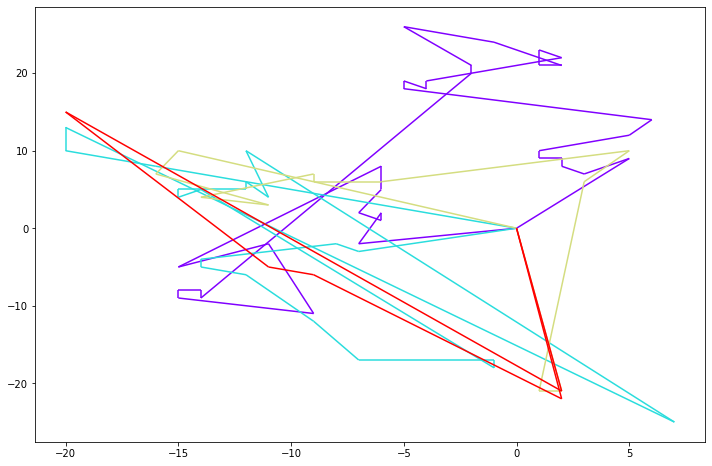

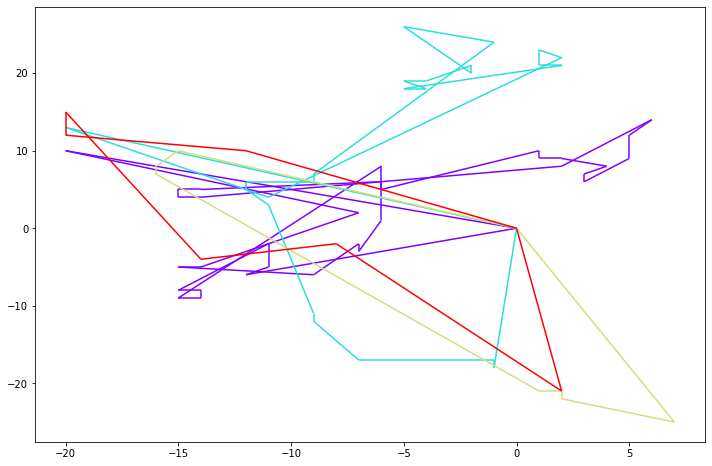

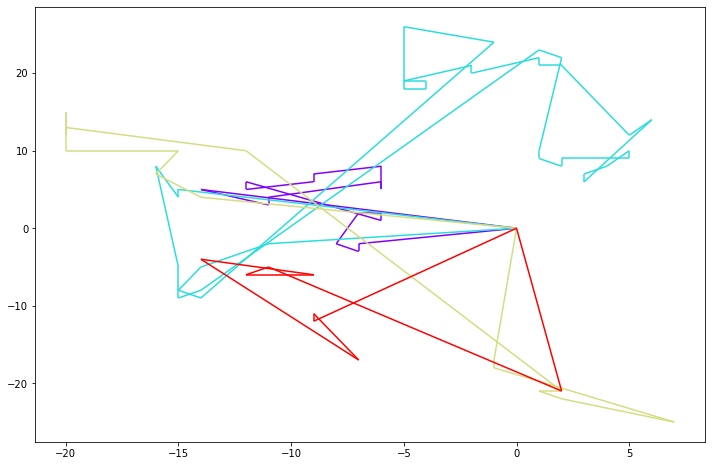

In [144]:
for n in ["32","72","422"]:
    load_data(n)
    best_solution, pheromones, cars = ant_solver(vertices, distance,len(nodes), max_iterations=3000)
    print("Best solution " + str(best_solution) + " number of cars " + str(len(cars)))
    print(cars)
    draw_data(best_solution, cars)

In [142]:
#TODO vykreslit ty auta, kazde jina barva
# rozdelit si to reseni do poli a kazdemu pridat cestu z nuly a do nuly, pak tomu pridat ty barvy bude ezy

def draw_data(best_solution,cars):
    solution = best_solution
    solution_list = []
    colors = cm.rainbow(np.linspace(0, 1, len(cars)))

    repeat1 = [0] + cars.copy()
    repeat1 = repeat1[:-1]

    repeat = np.array(cars) - np.array(repeat1)
    add = [0] + [1]*(len(cars)-2)+[2] 
    repeat = repeat + np.array(add)

    for i in range(len(cars)):
        if i == 0:
            c_p = 0
        else:
            c_p = cars[i-1]
        c = cars[i]
        if (c_p != 0):      
            solution_list.append([0] + solution[c_p:c])
        else:
            solution_list.append(solution[c_p:c])
        solution_list[-1].append(0)
    solution_list[-1] = solution_list[-1][:-1]
    solution_list[-1].extend(solution[c:])
    solution_list[-1].append(0)

    color_lines = np.repeat(colors,repeat, axis=0)

    #TODO pridat vsude nuly

    solution_lines = []
    for s in solution_list:
        for i, j in zip(s, s[1:]):
            solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])

    solutions_lc = mc.LineCollection(solution_lines, colors=color_lines)


    #lc = mc.LineCollection(lines, linewidths=np.array(colors))

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.add_collection(solutions_lc)
    ax.autoscale()

    solution = best_solution

    # tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
    # solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

    # vypiseme fitness reseni
    print('Fitness: ', fitness(vertices, distance, solution))
    print("number of cars ", best_num_cars)
    print("solution ", solution)

    # vypiseme primo poradi mest
    #solution_vertices = [vertices[i] for i in solution]
    #pprint.pprint(solution_vertices)